In [43]:
!pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [45]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('TATAMOTORS.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,TELCO,EQ,201.60,207.4,217.25,207.40,217.00,216.75,214.28,676126,1.448775e+13,0.0,0.0,0.0000
2000-01-04,TELCO,EQ,216.75,217.0,219.00,206.00,211.90,208.20,209.50,679215,1.422962e+13,0.0,0.0,0.0000
2000-01-05,TELCO,EQ,208.20,194.0,217.80,194.00,213.10,213.25,210.33,1120951,2.357684e+13,0.0,0.0,0.0000
2000-01-06,TELCO,EQ,213.25,215.0,229.90,215.00,222.00,222.10,225.29,1968998,4.435932e+13,0.0,0.0,0.0000
2000-01-07,TELCO,EQ,222.10,224.0,239.90,223.10,239.90,239.90,236.32,2199431,5.197636e+13,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,TATAMOTORS,EQ,294.00,297.0,299.00,294.60,295.85,295.40,296.48,30583139,9.067386e+14,173282.0,3291167.0,0.1076
2021-04-27,TATAMOTORS,EQ,295.40,295.7,302.50,295.10,302.10,301.50,299.05,35040532,1.047879e+15,191627.0,5215100.0,0.1488
2021-04-28,TATAMOTORS,EQ,301.50,303.5,309.50,303.00,305.15,305.90,307.22,44668126,1.372278e+15,264159.0,5116568.0,0.1145


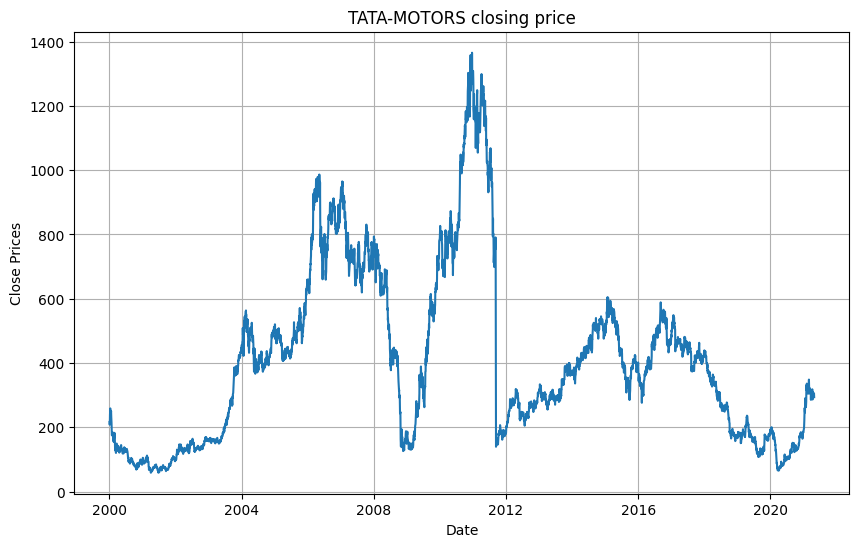

In [46]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TATA-MOTORS closing price')
plt.show()

<Axes: ylabel='Density'>

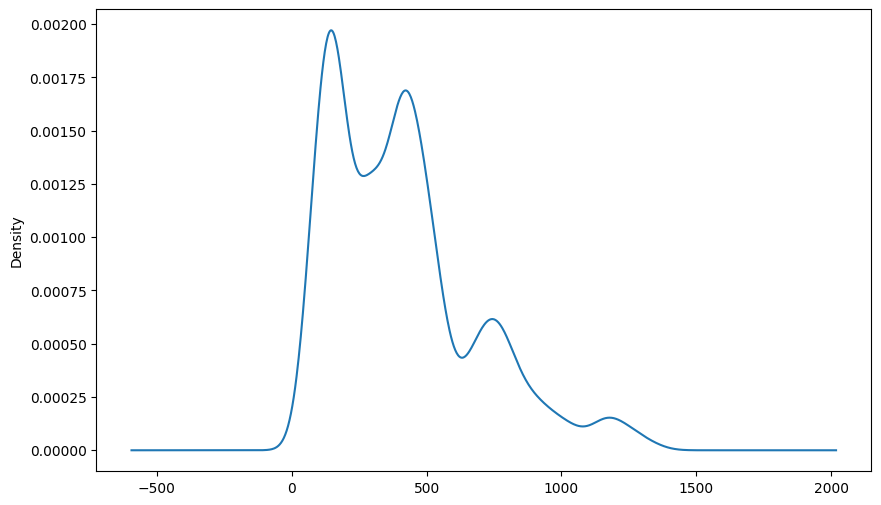

In [47]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

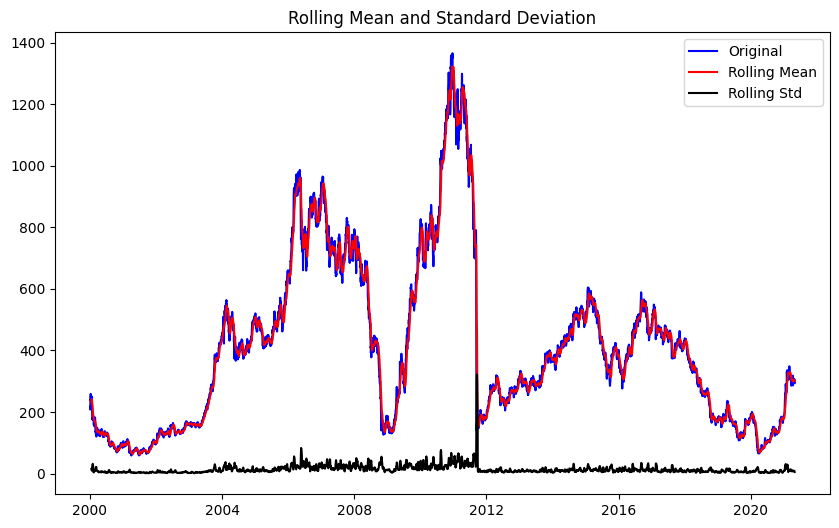

Results of dickey fuller test
Test Statistics                  -2.307609
p-value                           0.169526
No. of lags used                 22.000000
Number of observations used    5283.000000
critical value (1%)              -3.431588
critical value (5%)              -2.862087
critical value (10%)             -2.567061
dtype: float64


In [48]:
#Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

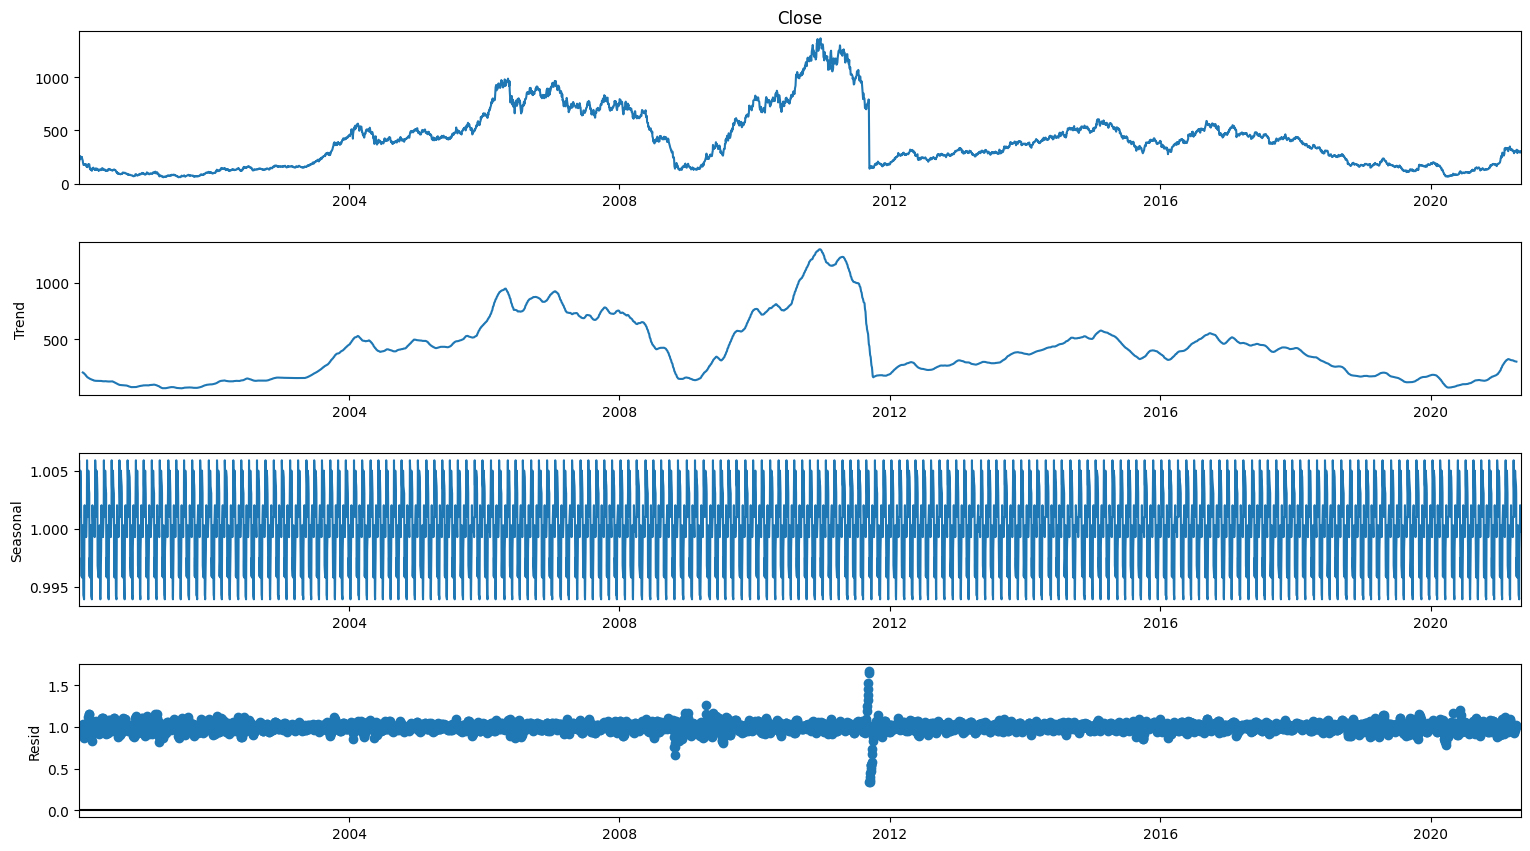

In [49]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

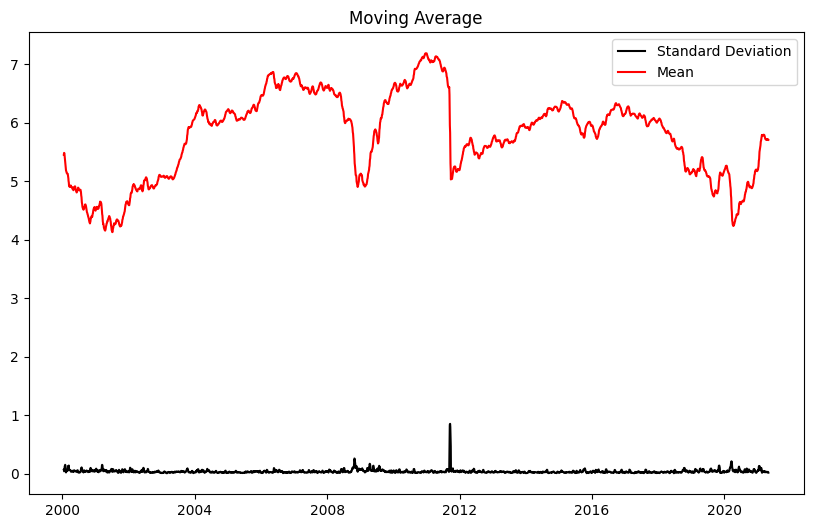

In [50]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

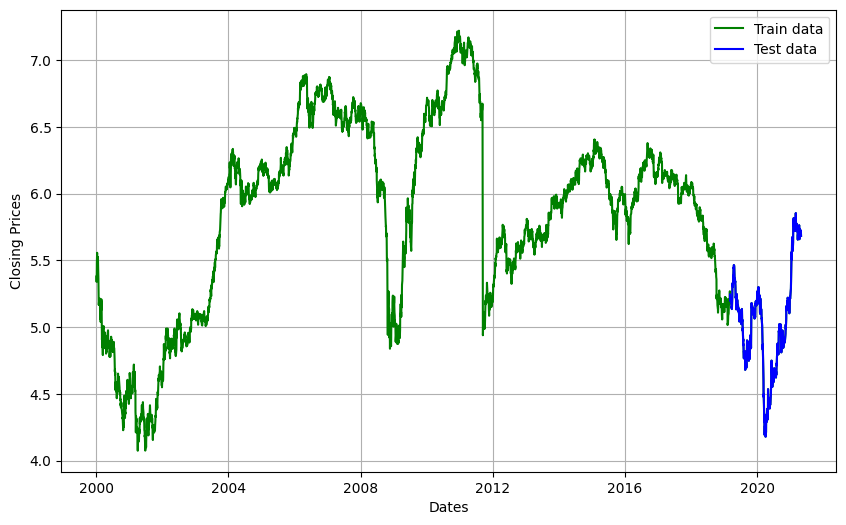

In [51]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18043.491, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18063.646, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18064.815, Time=4.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18045.487, Time=0.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18064.078, Time=3.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-18065.088, Time=3.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18068.434, Time=3.70 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18069.522, Time=15.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18044.917, Time=6.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-18063.125, Time=13.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-18065.212, Time=13.89 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-18068.088, Time=10.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18065.006, Time=2.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-18060.872, Time=14.02 sec


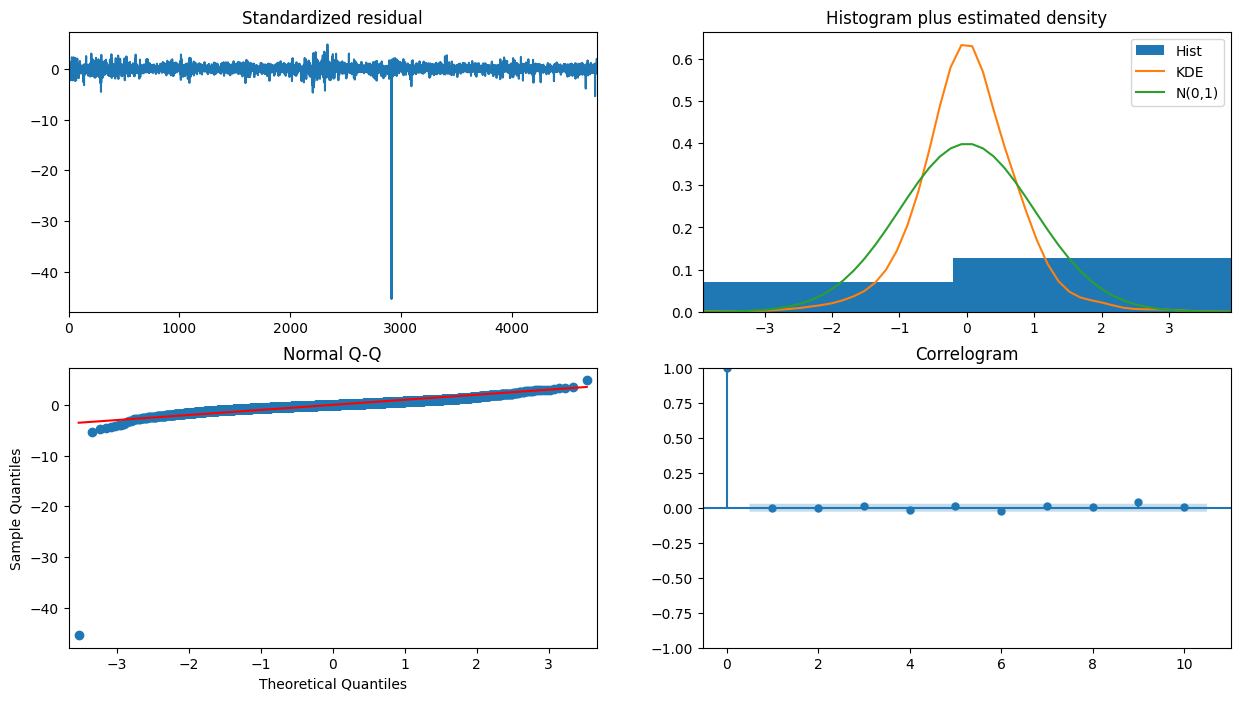

In [52]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [53]:
#Modeling
# Build Model

model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4772
Model:                 ARIMA(1, 1, 2)   Log Likelihood                9039.220
Date:                Thu, 27 Apr 2023   AIC                         -18070.440
Time:                        17:48:39   BIC                         -18044.559
Sample:                             0   HQIC                        -18061.348
                               - 4772                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6045      0.229      2.635      0.008       0.155       1.054
ma.L1         -0.5371      0.229     -2.346      0.019      -0.986      -0.088
ma.L2         -0.0736      0.016     -4.696      0.0

In [54]:
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  


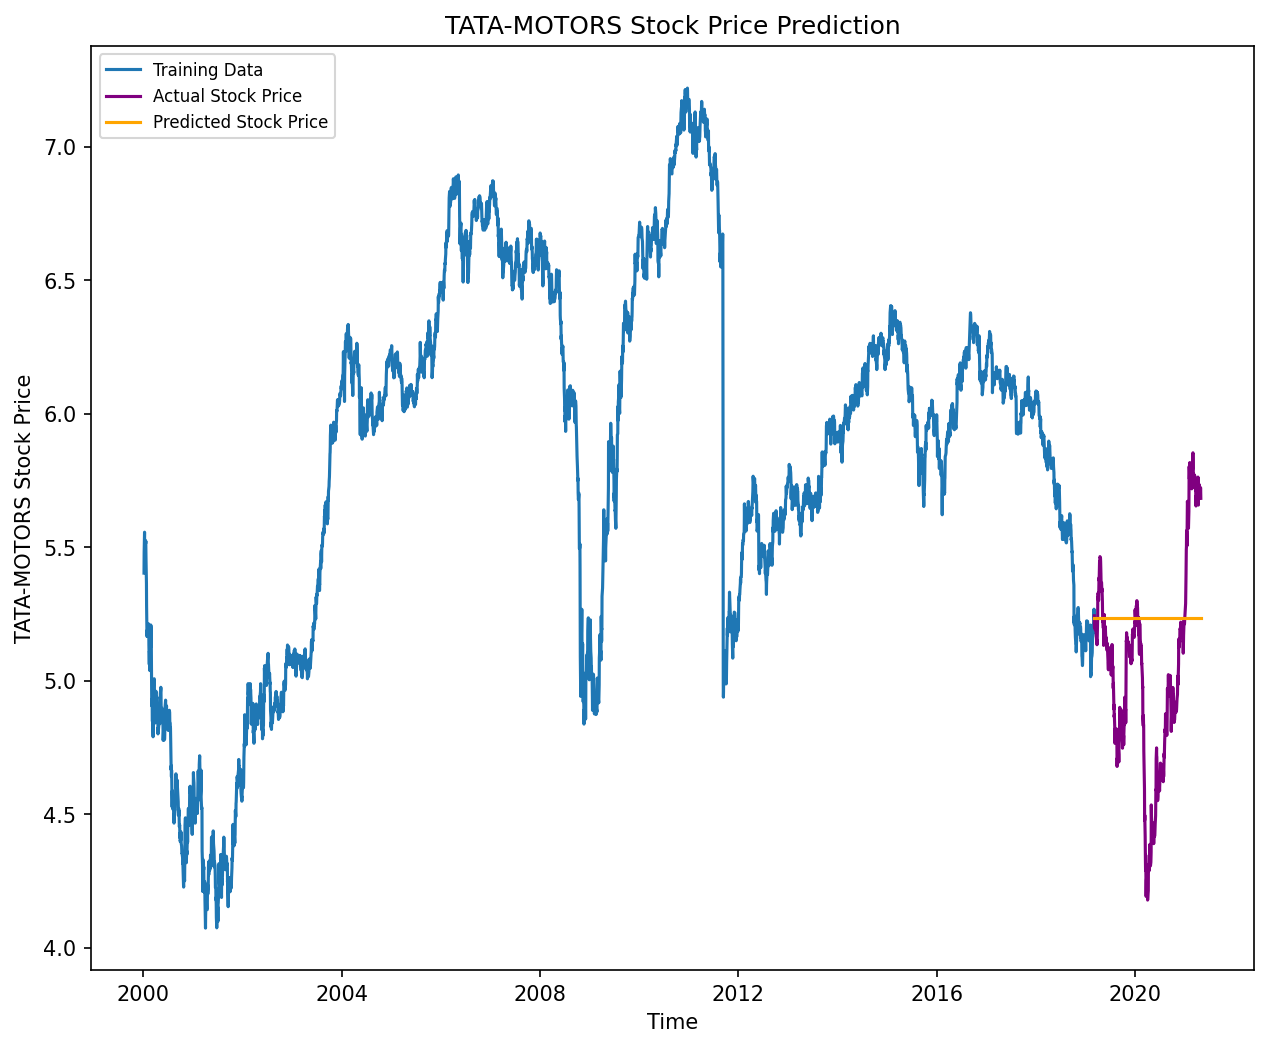

In [61]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf, index=test_data.index)
upper_series = pd.Series(conf, index=test_data.index)
# Plot
plt.figure(figsize=(10,8), dpi=150)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color = 'purple', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TATA-MOTORS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA-MOTORS Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [63]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse 
            })

forecast_accuracy(fc, test_data)

{'mape': 0.07007443935614936,
 'me': 0.19416759025336192,
 'mae': 0.3398369979131393,
 'mpe': 0.04448797957300328,
 'rmse': 0.42750927924173554}